In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import tqdm
from params import *
from deform_tools import deform_to_cycle_template

%matplotlib inline

In [3]:
save = False

In [4]:
ratio = 0.7

In [5]:
frontal_spindles_only = False

In [6]:
participants = patients

In [7]:
def inspi_to_expi_rsp_features(participant, rsp_features):
    spindles = pd.read_excel(f'../df_analyse/spindles_{participant}.xlsx', index_col = [0])
    if frontal_spindles_only:
        spindles = spindles[spindles['Channel'].isin(['Fp1-C3','Fp2-C4'])] # ONLY FRONTAL SPINDLES !!
    rows = []
    for i in rsp_features.index:
        if not i+1 in rsp_features.index: # tricks for cycles removed at detection cycle step
            continue
        if i != rsp_features.index[-1]:
            start = rsp_features.loc[i,'expi_time']
            transition = rsp_features.loc[i+1, 'inspi_time']
            stop = rsp_features.loc[i+1, 'expi_time']

            start_idx = rsp_features.loc[i,'expi_index']
            transition_idx = rsp_features.loc[i+1, 'inspi_index']
            stop_idx = rsp_features.loc[i+1, 'expi_index']

            participant = rsp_features.loc[i,'participant']

            expi_duration = transition - start
            inspi_duration = stop - transition
            cycle_duration = stop - start
            ratio_transition = expi_duration / cycle_duration
            
            n_spindles_in_cycle = spindles[(spindles['Peak'] >= start) & (spindles['Peak'] < stop)].shape[0]
            if n_spindles_in_cycle == 0:
                encoding = 0
            else:
                encoding = 1
            
            if cycle_duration < 20:
                rows.append([participant, start_idx, transition_idx, stop_idx, start , transition , stop, expi_duration, inspi_duration,  cycle_duration, ratio_transition, encoding, n_spindles_in_cycle])
    df_expi_rsp_features = pd.DataFrame(rows, columns = ['participant','start_idx','transition_idx','stop_idx','start_time','transition_time','stop_time','expi_duration','inspi_duration', 'cycle_duration','ratio_transition','spindled','n_spindles'])
    return df_expi_rsp_features

In [8]:
def tf_cycle_stretch_expi(da, rsp_features, nb_point_by_cycle=1000, expi_ratio =ratio):
    # da = 3d da ('raw',freqs * time)
    da_stretch_cycle = None
    for mode in ['raw','normal']:
        clipped_times, times_to_cycles, cycles, cycle_points, deformed_data = deform_to_cycle_template(data = da.loc[mode,:,:].values.T,
                                                                                                       times = da.coords['time'].values , 
                                                                                                       cycle_times=rsp_features[['start_time','transition_time']].values, 
                                                                                                       nb_point_by_cycle=nb_point_by_cycle,
                                                                                                       inspi_ratio = expi_ratio)
        deformed = deformed_data.T    

        for cycle in cycles:
            data_of_the_cycle = deformed[:,cycle*nb_point_by_cycle:(cycle+1)*nb_point_by_cycle]
            if da_stretch_cycle is None:
                da_stretch_cycle = gh.init_da({'normalisation':['raw','normal'],'cycle' : cycles, 'freqs': da.coords['freqs'].values , 'point':np.arange(0,nb_point_by_cycle,1)})
            da_stretch_cycle.loc[mode, cycle, : , :] = data_of_the_cycle
    new_rsp_features = rsp_features[rsp_features.index.isin(list(cycles))]
    return da_stretch_cycle, new_rsp_features

In [15]:
def get_midx_stretched_da(participant, df_all_expi_features):
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{participant}.nc')
    rsp_features_participant = df_all_expi_features[df_all_expi_features['participant'] == participant]
    print(participant, rsp_features_participant['spindled'].value_counts())
    da_stretch_cycle, new_rsp_features = tf_cycle_stretch_expi(da = da , rsp_features = rsp_features_participant)
    da_stretch_midx = gh.midx_da(da = da_stretch_cycle , dim = 'cycle', midx_labels = ('c','spindling','n_spindles'), midx_coords = [new_rsp_features.index, list(new_rsp_features.loc[:,'spindled']), list(new_rsp_features.loc[:,'n_spindles'])])
    mean_cycle_da = da_stretch_midx.groupby('spindling').mean()
    all_cycles = mean_cycle_da.mean('spindling')
    unspindled = mean_cycle_da.sel(spindling=0).drop('spindling')
    spindled = mean_cycle_da.sel(spindling=1).drop('spindling')
    diff = spindled - unspindled
    da_return = xr.concat([all_cycles, spindled, unspindled, diff], dim = 'spindle_mode').assign_coords({'spindle_mode':['all','spindled','unspindled','diff']})
    return da_return

In [11]:
concat = []
for participant in participants:
    print(participant)
    concat.append(inspi_to_expi_rsp_features(participant, rsp_features=pd.read_excel(f'../df_analyse/resp_features_{participant}.xlsx', index_col = 0)))
df_all_expi_features = pd.concat(concat)

P1
P2
P3
P4
P5
P6
P7
P9
P10


In [35]:
df_all_expi_features.describe()

,start_idx,transition_idx,stop_idx,start_time,transition_time,stop_time,expi_duration,inspi_duration,cycle_duration,ratio_transition,spindled,n_spindles
count,3.234200e+04,3.234200e+04,3.234200e+04,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000,32342.000000
mean,1.821713e+06,1.822347e+06,1.822707e+06,7116.068353,7118.543494,7119.947777,2.475141,1.404283,3.879424,0.635027,0.303970,0.897749
std,1.118117e+06,1.118163e+06,1.118169e+06,4367.644162,4367.825633,4367.846443,0.588994,0.318312,0.718387,0.059053,0.459977,1.724643
min,4.340000e+02,9.130000e+02,1.202000e+03,1.695312,3.566406,4.695312,0.917969,0.503906,1.703125,0.177396,0.000000,0.000000
25%,8.575072e+05,8.581170e+05,8.583930e+05,3349.637695,3352.019531,3353.097656,2.058594,1.195312,3.402344,0.605894,0.000000,0.000000
50%,1.773386e+06,1.774021e+06,1.774327e+06,6927.289062,6929.769531,6930.964844,2.394531,1.410156,3.851562,0.633760,0.000000,0.000000
75%,2.675789e+06,2.676544e+06,2.676880e+06,10452.300781,10455.250000,10456.561523,2.816406,1.562500,4.277344,0.663061,1.000000,1.000000
max,4.751515e+06,4.752196e+06,4.752377e+06,18560.605469,18563.265625,18563.972656,9.757812,8.796875,11.828125,0.920723,1.000000,15.000000


In [17]:
df_all_expi_features['n_spindles'].value_counts()

0     22511
1      2966
2      1961
3      1574
4      1244
5       951
6       601
7       329
8       130
9        41
10       15
11        8
12        7
13        3
15        1
Name: n_spindles, dtype: int64

In [ ]:
concat= []
for participant in participants:
    concat.append(get_midx_stretched_da(participant, df_all_expi_features))
da_all = xr.concat(concat, dim = 'participant').assign_coords({'participant':participants})

P1 0    2597
1    1041
Name: spindled, dtype: int64


In [14]:
da_all = xr.concat(concat, dim = 'participant').assign_coords({'participant':participants})

In [15]:
da_all

<xarray.DataArray (participant: 10, spindle_mode: 4, normalisation: 2, freqs: 40, point: 1000)>
array([[[[[ 7.21662373e+03,  7.21831740e+03,  7.21969202e+03, ...,
            7.55074199e+03,  7.55260966e+03,  7.55493001e+03],
          [ 6.59414925e+03,  6.59566880e+03,  6.59690958e+03, ...,
            6.88278439e+03,  6.88456364e+03,  6.88687161e+03],
          [ 6.13352846e+03,  6.13464960e+03,  6.13553645e+03, ...,
            6.37178152e+03,  6.37291033e+03,  6.37458844e+03],
          ...,
          [ 6.92265387e+02,  6.92605282e+02,  6.92886968e+02, ...,
            7.03444753e+02,  7.03848953e+02,  7.04219245e+02],
          [ 6.69544598e+02,  6.69534195e+02,  6.69467486e+02, ...,
            6.81671187e+02,  6.81851158e+02,  6.81992241e+02],
          [ 6.46206045e+02,  6.45813215e+02,  6.45369079e+02, ...,
            6.59624421e+02,  6.59577601e+02,  6.59483572e+02]],

         [[ 1.96043316e-01,  1.96174691e-01,  1.96281318e-01, ...,
            2.21960269e-01,  2.22105141e-01,  2.22285127e-01],
          [ 1.47759088e-01,  1.47876957e-01,  1.47973201e-01, ...,
            1.70147997e-01,  1.70286010e-01,  1.70465036e-01],
          [ 1.12029559e-01,  1.12116524e-01,  1.12185315e-01, ...,
            1.30510421e-01,  1.30597981e-01,  1.30728149e-01],
...
          [-3.37797061e+02, -3.35460561e+02, -3.32673167e+02, ...,
           -4.26742408e+02, -4.23977106e+02, -4.17561773e+02],
          [-3.35839229e+02, -3.32774928e+02, -3.29217887e+02, ...,
           -4.20982554e+02, -4.17887972e+02, -4.10001715e+02],
          [-3.33106355e+02, -3.29373346e+02, -3.25106871e+02, ...,
           -4.13335736e+02, -4.09661536e+02, -4.00416650e+02]],

         [[-1.19853024e-01, -1.19171443e-01, -1.18518652e-01, ...,
            6.15482385e-03,  4.85628293e-03,  2.36683435e-03],
          [-1.03995664e-01, -1.03066974e-01, -1.02168711e-01, ...,
            4.57981856e-02,  4.49788359e-02,  4.26074338e-02],
          [-9.07394200e-02, -8.96192176e-02, -8.85286662e-02, ...,
            8.67002646e-02,  8.60274631e-02,  8.38381362e-02],
          ...,
          [-4.80403239e-02, -4.77080353e-02, -4.73116221e-02, ...,
           -6.06898220e-02, -6.02965511e-02, -5.93841845e-02],
          [-4.77618874e-02, -4.73260931e-02, -4.68202231e-02, ...,
           -5.98706769e-02, -5.94305752e-02, -5.83090191e-02],
          [-4.73732277e-02, -4.68423323e-02, -4.62355690e-02, ...,
           -5.87831731e-02, -5.82606406e-02, -5.69458650e-02]]]]])
Coordinates:
  * normalisation  (normalisation) <U6 'raw' 'normal'
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * point          (point) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * spindle_mode   (spindle_mode) <U10 'all' 'spindled' 'unspindled' 'diff'
  * participant    (participant) <U3 'P1' 'P2' 'P3' 'P4' ... 'P8' 'P9' 'P10'

In [16]:
da = da_all.sel(normalisation = 'normal')

In [17]:
xvline = ratio * 1000
expi_label_pos = xvline / 2
inspi_label_pos = 1000 - ((1000-xvline)/2)

In [18]:
if frontal_spindles_only:
    save_title_append = '_frontal_spindle_only'
else:
    save_title_append = None

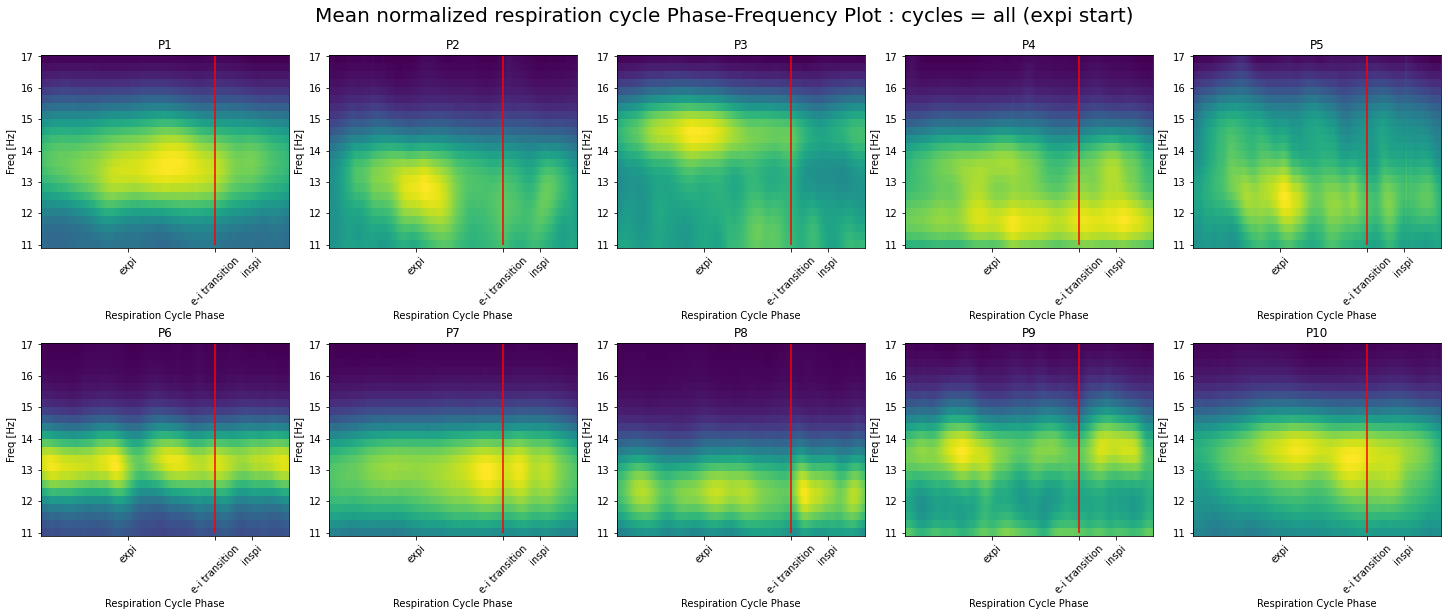

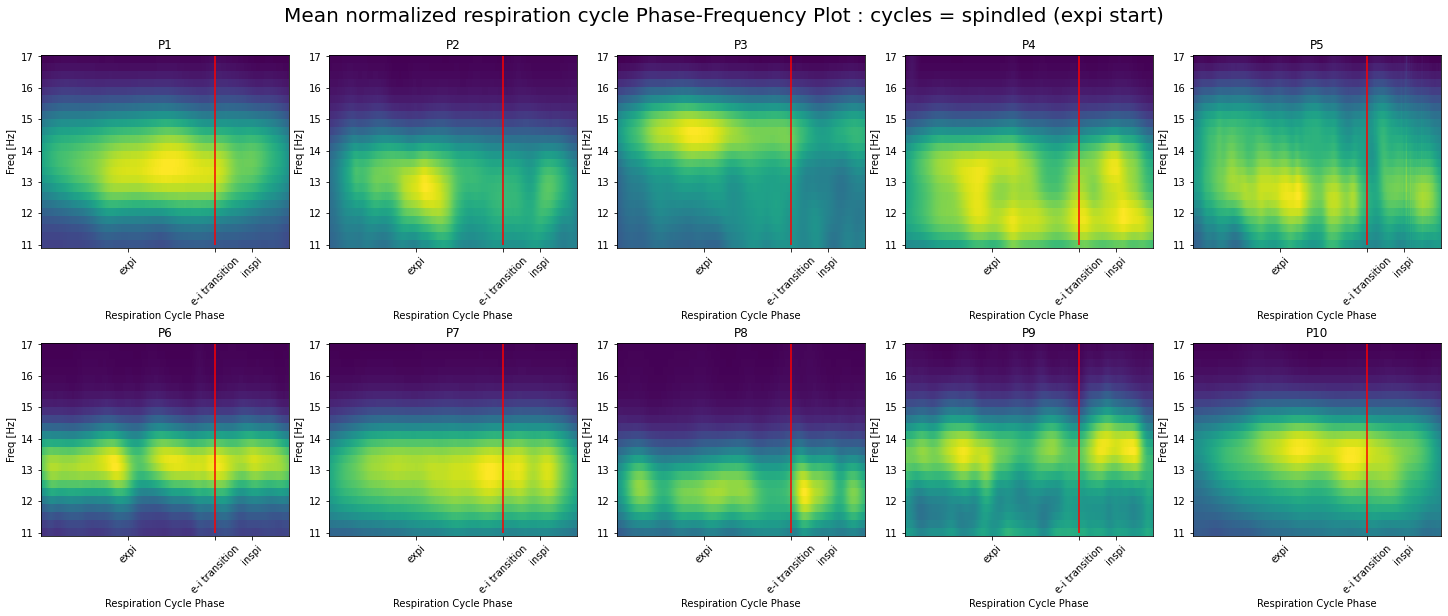

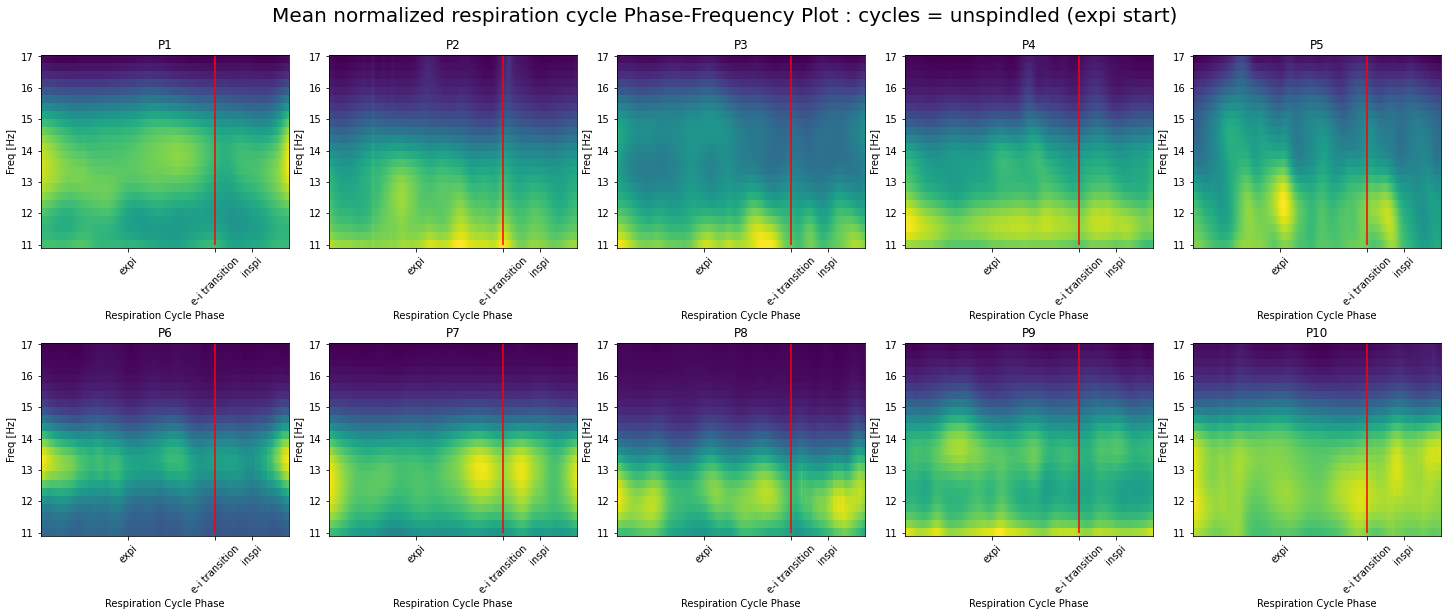

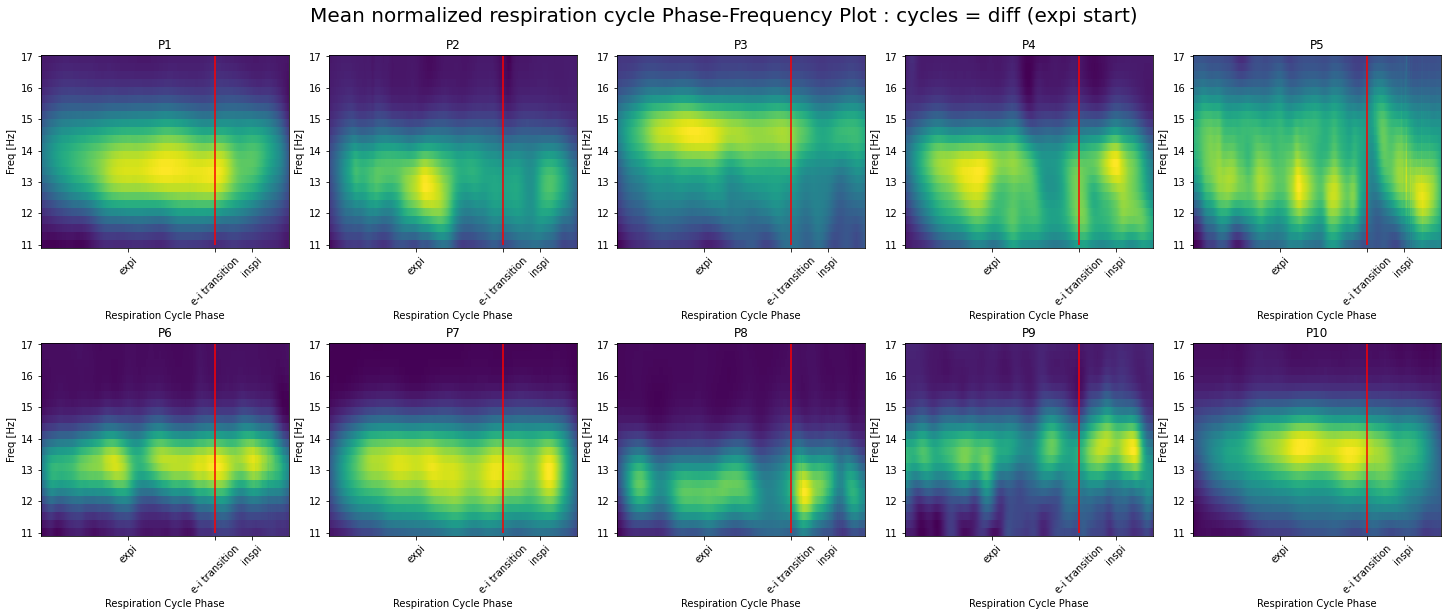

In [19]:
for mode in da.coords['spindle_mode'].values:
    fig, axs = plt.subplots(ncols = 5, nrows = 2, constrained_layout = True, figsize = (20,8))
    fig.suptitle(f'Mean normalized respiration cycle Phase-Frequency Plot : cycles = {mode} (expi start)', fontsize = 20, y = 1.05)
    for row, sublists in enumerate([ participants[:5] , participants[5:] ]): 
        for col, participant in enumerate(sublists):
            ax = axs[row, col]
            min_freq = 11
            max_freq = 17
            data = da.loc[participant, mode , min_freq:max_freq,:].values
            ax.pcolormesh(da.coords['point'], da.coords['freqs'].loc[min_freq:max_freq], data)
            ax.set_title(participant)
            ax.set_ylabel('Freq [Hz]')
            ax.set_xlabel('Respiration Cycle Phase')
            ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
            ax.set_xticks([expi_label_pos,xvline,inspi_label_pos])
            ax.set_xticklabels(['expi','e-i transition','inspi'], rotation=45, fontsize=10)
    if save:
        plt.savefig(f'../presentation_4/stretch_tf_by_participant_{mode}_expi_start{save_title_append}', bbox_inches = 'tight')
    plt.show()

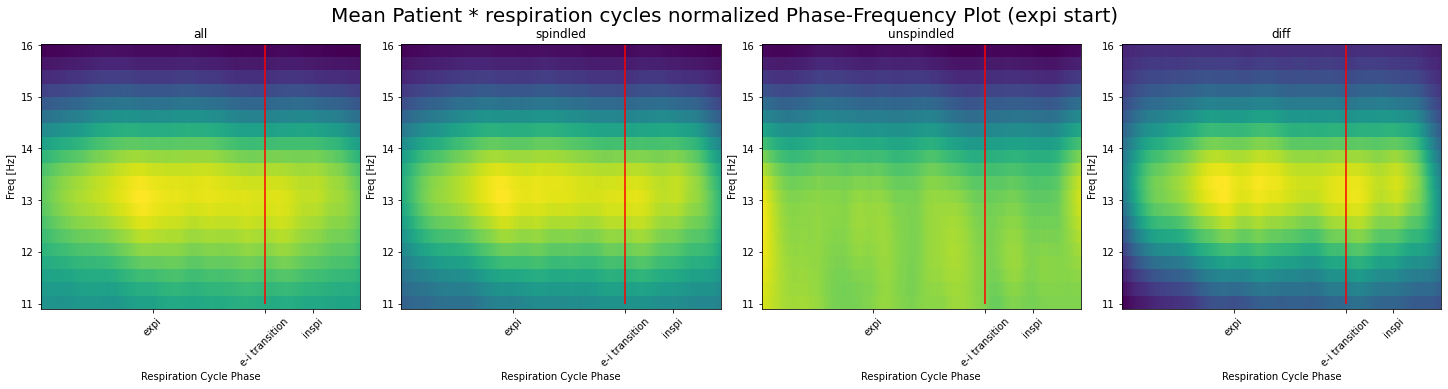

In [20]:
fig, axs = plt.subplots(ncols = 4, constrained_layout = True, figsize = (20,5))
fig.suptitle('Mean participant * respiration cycles normalized Phase-Frequency Plot (expi start)', fontsize = 20, y = 1.05)
min_freq = 11
max_freq = 16

for col, mode in enumerate(da.coords['spindle_mode'].values):
    ax = axs[col]
    data = da.loc[:, mode , min_freq:max_freq,:].mean('participant').values
    ax.pcolormesh( da.coords['point'] , da.coords['freqs'].loc[min_freq:max_freq] , data)
    ax.set_title(mode)
    ax.set_ylabel('Freq [Hz]')
    ax.set_xlabel('Respiration Cycle Phase')
    ax.vlines(x = xvline, ymin = min_freq, ymax=max_freq, color = 'r')
    ax.set_xticks([expi_label_pos,xvline,inspi_label_pos])
    ax.set_xticklabels(['expi','e-i transition','inspi'], rotation=45, fontsize=10)
if save:
    plt.savefig(f'../presentation_4/stretch_tf_mean_participant_modes_expi_start{save_title_append}', bbox_inches = 'tight')
plt.show()

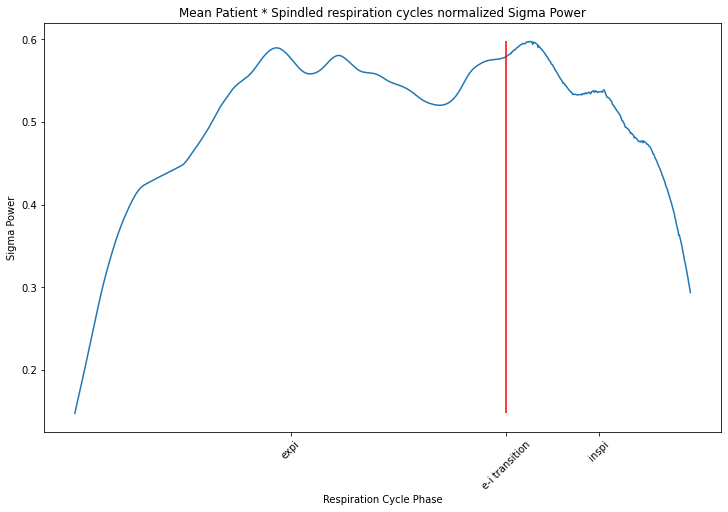

In [21]:
fig, ax = plt.subplots(constrained_layout = True, figsize = (10,7))
min_freq = 12
max_freq = 13
data = da.loc[:, 'diff' , min_freq:max_freq,:].mean(['participant','freqs']).values
ax.plot(da.coords['point'], data)
ax.set_title('Mean participant * Spindled respiration cycles normalized Sigma Power')
ax.set_ylabel('Sigma Power')
ax.set_xlabel('Respiration Cycle Phase')
ax.vlines(x = xvline, ymin = min(data), ymax=max(data), color = 'r')
ax.set_xticks([expi_label_pos,xvline,inspi_label_pos])
ax.set_xticklabels(['expi','e-i transition','inspi'], rotation=45, fontsize=10)
if save:
    plt.savefig(f'../presentation_4/stretch_sigma_power_mean_participant_expi_start{save_title_append}', bbox_inches = 'tight')
plt.show()